baseline.csv<br>
.. ├ models<br>
.. └ data<br>
.... ├ public_data<br>
.... │ .. ├ train_AT_TSALET_ALL<br>
.... │ .. ├ test_AT_TSALET_ALL<br>
.... │ .. ├ test_files<br>
.... │ .. └ train.csv<br>
.... ├ prviate_data<br>
.... │ .. ├ AT_TSALET_ALL<br>
.... │ .. ├ private_data<br>
.... └ sample_submission.csv<br>

## 사용 패키지

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

## 재현을 위한 랜덤시드 고정

In [ ]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [ ]:
seed_everything(42)

## 데이터 로드

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Dacon_data/public_data/train.csv')

In [ ]:
data.head()

,date,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),건고추_거래량(kg),건고추_가격(원/kg),마늘_거래량(kg),마늘_가격(원/kg),대파_거래량(kg),대파_가격(원/kg),얼갈이배추_거래량(kg),얼갈이배추_가격(원/kg),양배추_거래량(kg),양배추_가격(원/kg),깻잎_거래량(kg),깻잎_가격(원/kg),시금치_거래량(kg),시금치_가격(원/kg),미나리_거래량(kg),미나리_가격(원/kg),당근_거래량(kg),당근_가격(원/kg),파프리카_거래량(kg),파프리카_가격(원/kg),새송이_거래량(kg),새송이_가격(원/kg),팽이버섯_거래량(kg),팽이버섯_가격(원/kg),토마토_거래량(kg),토마토_가격(원/kg),청상추_거래량(kg),청상추_가격(원/kg),백다다기_거래량(kg),백다다기_가격(원/kg),애호박_거래량(kg),애호박_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
0,2016-01-01,금요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-02,토요일,80860.0,329.0,80272.0,360.0,122787.5,1281.0,3.0,11000.0,15019.0,5475.0,92334.0,1704.0,6359.0,1331.0,40028.0,348.0,4374.9,13242.0,16550.5,2339.0,10528.0,1729.0,13885.0,804.0,3853.0,3703.0,15797.0,2576.0,14634.0,1474.0,30950.0,1621.0,5125.0,9235.0,434.0,2109.0,19159.0,2414.0,880.0,2014.0,0.0,0.0
2,2016-01-03,일요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-01-04,월요일,1422742.5,478.0,1699653.7,382.0,2315079.0,1235.0,699.0,4464.0,141638.0,5210.0,994328.1,1716.0,262615.5,1212.0,1074699.1,345.0,122613.5,9923.0,427435.1,2153.0,82113.5,3960.0,558950.2,794.0,104930.3,4871.0,277326.5,2440.0,159800.0,1750.0,291057.0,1834.0,38525.5,7631.0,500702.0,2046.0,620539.0,2018.0,2703.8,3885.0,0.0,0.0
4,2016-01-05,화요일,1167241.0,442.0,1423482.3,422.0,2092960.1,1213.0,1112.6,4342.0,126207.8,5387.0,787716.0,1715.0,221850.5,1197.0,825681.9,350.0,79055.9,9529.0,334636.8,2220.0,80144.0,3333.0,444353.7,763.0,100699.5,5129.0,218465.2,2437.0,153084.0,1822.0,194626.5,1833.0,32615.0,6926.0,147638.0,2268.0,231958.0,2178.0,8810.0,2853.0,0.0,0.0


## 데이터 정규화

요일을 0 ~ 6으로 변환 후 각 컬럼 최대값으로 나눠 0 ~ 1값으로 정규화 진행

In [ ]:
week_day_map = {}
for i, d in enumerate(data['요일'].unique()):
    week_day_map[d] = i
data['요일'] = data['요일'].map(week_day_map)

In [ ]:
norm = data.iloc[:, 1:].max(0)
data.iloc[:, 1:] = data.iloc[:, 1:] / norm

## 하이퍼파라미터

In [ ]:
device = torch.device("cuda:0") # GPU 사용
target_n = 21 # 맞춰야하는 품목/품종의 수
learning_rate = 5e-4 # 학습률
BATCH_SIZE = 128 # 배치사이즈
EPOCHS = 50 # 총 eopochs
teacher_forcing = False # 교사강요 설정
n_layers = 3 # rnn레이어 층
dropout = 0.2 # 드롭아웃
window_size = 28 # 인코더 시퀀스 길이
future_size = 28 # 디코더 시퀀스 길이
hidden_dim = 128 # rnn 히든차원
save_path = f'/content/drive/MyDrive/Colab Notebooks/ model/best_model.pt' # 모델 저장 경로

## 전처리
시계열 학습이 가능한 형태로 전처리

과거 28일의 변화를 보고 미래 28일을 예측

In [ ]:
data

,date,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),건고추_거래량(kg),건고추_가격(원/kg),마늘_거래량(kg),마늘_가격(원/kg),대파_거래량(kg),대파_가격(원/kg),얼갈이배추_거래량(kg),얼갈이배추_가격(원/kg),양배추_거래량(kg),양배추_가격(원/kg),깻잎_거래량(kg),깻잎_가격(원/kg),시금치_거래량(kg),시금치_가격(원/kg),미나리_거래량(kg),미나리_가격(원/kg),당근_거래량(kg),당근_가격(원/kg),파프리카_거래량(kg),파프리카_가격(원/kg),새송이_거래량(kg),새송이_가격(원/kg),팽이버섯_거래량(kg),팽이버섯_가격(원/kg),토마토_거래량(kg),토마토_가격(원/kg),청상추_거래량(kg),청상추_가격(원/kg),백다다기_거래량(kg),백다다기_가격(원/kg),애호박_거래량(kg),애호박_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
0,2016-01-01,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1,2016-01-02,0.166667,0.015520,0.0658,0.020797,0.264706,0.024437,0.6405,0.000007,0.064389,0.013751,0.853468,0.070877,0.535512,0.010287,0.442634,0.034353,0.216283,0.017059,0.924333,0.024831,0.166905,0.056230,0.206571,0.018154,0.214400,0.012547,0.283559,0.050133,0.64400,0.086461,0.373070,0.024183,0.220604,0.060900,0.511068,0.000197,0.398376,0.023032,0.356152,0.000590,0.08056,0.000000,0.000000
2,2016-01-03,0.333333,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,2016-01-04,0.500000,0.273068,0.0956,0.440354,0.280882,0.460735,0.6175,0.001690,0.026130,0.129684,0.812159,0.763265,0.539283,0.424853,0.403060,0.922336,0.214419,0.478118,0.692657,0.641277,0.153632,0.438569,0.473118,0.730787,0.211733,0.341704,0.372999,0.880117,0.61000,0.944132,0.442926,0.227416,0.249592,0.457792,0.422302,0.227365,0.386475,0.745976,0.297728,0.001814,0.15540,0.000000,0.000000
4,2016-01-05,0.666667,0.224029,0.0884,0.368802,0.310294,0.416530,0.6065,0.002690,0.025416,0.115556,0.839751,0.604666,0.538969,0.358904,0.398071,0.708623,0.217526,0.308270,0.665154,0.502053,0.158413,0.428050,0.398208,0.580960,0.203467,0.327927,0.392756,0.693316,0.60925,0.904452,0.461149,0.152071,0.249456,0.387559,0.383287,0.067041,0.428410,0.278846,0.321334,0.005911,0.11412,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728,2020-09-24,1.000000,0.356409,0.3678,0.532584,0.727941,0.454038,0.4950,0.006813,0.111809,0.123020,0.744349,0.591275,0.747957,0.713114,0.621217,0.563427,0.710379,0.310033,0.699986,0.104786,0.451620,0.320572,0.591398,0.553347,0.417333,0.306607,0.704954,0.637287,0.73175,0.768054,0.644141,0.111332,0.760343,0.602816,0.249530,0.128151,0.566868,0.376438,0.505459,0.338341,0.14480,0.740842,0.273500
1729,2020-09-25,0.000000,0.360848,0.3578,0.486887,0.743382,0.412859,0.4775,0.004562,0.135188,0.116213,0.785503,0.599806,0.703646,0.685951,0.680745,0.615180,0.677439,0.330832,0.762320,0.133999,0.446839,0.665987,0.310036,0.523660,0.472800,0.283729,0.695612,0.707492,0.74850,0.770308,0.657555,0.119214,0.761568,0.645499,0.231212,0.141775,0.566490,0.436066,0.495279,0.321862,0.14472,0.794687,0.271100
1730,2020-09-26,0.166667,0.318814,0.3520,0.442875,0.790441,0.415758,0.4805,0.002318,0.131764,0.101044,0.867498,0.622395,0.668133,0.670464,0.696708,0.431408,0.824114,0.387790,0.740402,0.186425,0.508277,0.405116,0.514934,0.244589,0.374667,0.334350,0.704342,0.790250,0.73550,0.768347,0.662364,0.138147,0.716113,0.727384,0.208633,0.148668,0.578957,0.469269,0.456182,0.349917,0.14764,0.819581,0.265900
1731,2020-09-27,0.333333,0.004874,0.6132,0.009903,0.837500,0.003630,0.5280,0.000145,0.130728,0.000568,0.814809,0.014041,0.586

In [ ]:
x_data = []
y_data = []
for i in range(data.shape[0]-window_size-future_size):
    x = data.iloc[i:i+window_size, 1:].to_numpy()
    y = data.iloc[i+window_size:i+window_size+future_size, 3::2].to_numpy()
    y_0 = np.zeros([1, y.shape[1]]) # 디코더 첫 입력값 추가
    x_data.append(x)
    y_data.append(np.concatenate([y_0, y], axis=0))
x_data = np.array(x_data)
y_data = np.array(y_data)

In [ ]:
x_data

NameError: ignored

In [ ]:
y_data

In [ ]:
x_data.shape, y_data.shape

((1677, 28, 43), (1677, 29, 21))

In [ ]:
train_test_split = 1
x_train = x_data[:-train_test_split-future_size]
y_train = y_data[:-train_test_split-future_size]
x_val = x_data[-train_test_split:]
y_val = y_data[-train_test_split:]

In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1648, 28, 43), (1648, 29, 21), (1, 28, 43), (1, 29, 21))

## 데이터셋 정의

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, encoder_input, decoder_input):
        self.encoder_input = encoder_input
        self.decoder_input = decoder_input
        
    def __len__(self):
        return len(self.encoder_input)
    
    def __getitem__(self, i):
        return {
            'encoder_input' : torch.tensor(self.encoder_input[i], dtype=torch.float32),
            'decoder_input' : torch.tensor(self.decoder_input[i], dtype=torch.float32)
        }

In [ ]:
train_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
sample_batch = next(iter(train_dataloader))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
sample_batch['encoder_input'].shape, sample_batch['decoder_input'].shape

(torch.Size([128, 28, 43]), torch.Size([128, 29, 21]))

## 모델

어텐션이 적용된 seq2seq모델

인코더와 디코더는 GRU 사용

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.n_layers = n_layers
        
        self.rnn = nn.GRU(input_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp_seq):
        inp_seq = inp_seq.permute(1,0,2)
        outputs, hidden = self.rnn(inp_seq)
        
        return outputs, hidden

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, dec_output_dim, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = nn.Linear(dec_output_dim, units)
        self.W2 = nn.Linear(dec_output_dim, units)
        self.V = nn.Linear(dec_output_dim, 1)

    def forward(self, hidden, enc_output):
        query_with_time_axis = hidden.unsqueeze(1)
        
        score = self.V(torch.tanh(self.W1(query_with_time_axis) + self.W2(enc_output)))
        
        attention_weights = torch.softmax(score, axis=1)
        
        context_vector = attention_weights * enc_output
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector, attention_weights

In [ ]:
class Decoder(nn.Module):
    def __init__(self, dec_feature_size, encoder_hidden_dim, output_dim, decoder_hidden_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.decoder_hidden_dim = decoder_hidden_dim
        self.n_layers = n_layers
        self.attention = attention
        
        self.layer = nn.Linear(dec_feature_size, encoder_hidden_dim)
        self.rnn = nn.GRU(encoder_hidden_dim*2, decoder_hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, enc_output, dec_input, hidden):
        dec_input = self.layer(dec_input)
        context_vector, attention_weights = self.attention(hidden, enc_output)
        dec_input = torch.cat([torch.sum(context_vector, dim=0), dec_input], dim=1)
        dec_input = dec_input.unsqueeze(0)
        
        output, hidden = self.rnn(dec_input, hidden)

        prediction = self.fc_out(output.sum(0))
        
        return prediction, hidden

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, attention):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, encoder_input, decoder_input, teacher_forcing=False):
        batch_size = decoder_input.size(0)
        trg_len = decoder_input.size(1)
        
        outputs = torch.zeros(batch_size, trg_len-1, self.decoder.output_dim).to(device)
        enc_output, hidden = self.encoder(encoder_input)
        
        dec_input = decoder_input[:, 0]
        for t in range(1, trg_len):
            output, hidden = self.decoder(enc_output, dec_input, hidden)
            outputs[:, t-1] = output
            if teacher_forcing == True:
                dec_input = decoder_input[:, t]
            else:
                dec_input = output
        
        return outputs

In [ ]:
encoder = Encoder(input_dim=x_data.shape[-1], hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout)
attention = BahdanauAttention(dec_output_dim=hidden_dim, units=hidden_dim)
decoder = Decoder(
    dec_feature_size=target_n, encoder_hidden_dim=hidden_dim, output_dim=target_n,
    decoder_hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout,
    attention = attention
)

model = Seq2Seq(encoder, decoder, attention)
model = model.to(device)

## 평가 함수

평가를 위한 NMAE 정의

In [ ]:
def my_custom_metric(pred, true):
    pred = pred[:, [6, 13, 27]]
    true = true[:, [6, 13, 27]]
    target = torch.where(true!=0)
    true = true[target]
    pred = pred[target]
    score = torch.mean(torch.abs((true-pred))/(true))
    
    return score

## 옵티마이저 및 손실함수

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.L1Loss() # mae
custom_metric = my_custom_metric

## 학습 정의

In [ ]:
def train_step(batch_item, epoch, batch, training, teacher_forcing):
    encoder_input = batch_item['encoder_input'].to(device)
    decoder_input = batch_item['decoder_input'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(encoder_input, decoder_input, teacher_forcing)
            loss = criterion(output, decoder_input[:,1:])
            score = custom_metric(output, decoder_input[:,1:])
        loss.backward()
        optimizer.step()
        
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(encoder_input, decoder_input, False)
            loss = criterion(output, decoder_input[:,1:])
            score = custom_metric(output, decoder_input[:,1:])
        return loss, score

## 학습

In [ ]:
!pwd

/content


In [ ]:
loss_plot, val_loss_plot = [], []
score_plot, val_score_plot = [], []

for epoch in range(EPOCHS):
    total_loss, total_val_loss = 0, 0
    total_score, total_val_score = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_score = train_step(batch_item, epoch, batch, training, teacher_forcing)
        total_loss += batch_loss
        total_score += batch_score
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Score': '{:06f}'.format(batch_score.item()),
            'Total Score' : '{:06f}'.format(total_score/(batch+1)),
        })
    loss_plot.append(total_loss/(batch+1))
    score_plot.append(total_score/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_val_score = train_step(batch_item, epoch, batch, training, teacher_forcing)
        total_val_loss += batch_loss
        total_val_score += batch_val_score
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Val Score': '{:06f}'.format(batch_val_score.item()),
            'Total Val Score' : '{:06f}'.format(total_val_score/(batch+1)),
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_score_plot.append(total_val_score/(batch+1))
    
    if np.min(val_loss_plot) == val_loss_plot[-1]:
        torch.save(model, save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
13it [00:04,  2.79it/s, Epoch=1, Loss=0.143691, Total Loss=0.180263, Score=0.379739, Total Score=0.576583]
1it [00:00,  3.87it/s, Epoch=1, Val Loss=0.246930, Total Val Loss=0.246930, Val Score=0.426005, Total Val Score=0.426005]
13it [00:04,  2.98it/s, Epoch=2, Loss=0.123758, Total Loss=0.131610, Score=0.343928, Total Score=0.366073]
1it [00:00,  3.80it/s, Epoch=2, Val Loss=0.233278, Total Val Loss=0.233278, Val Score=0.464174, Total Val Score=0.464174]
13it [00:04,  3.00it/s, Epoch=3, Loss=0.116190, Total Loss=0.122500, Score=0.335143, 

## 학습 결과

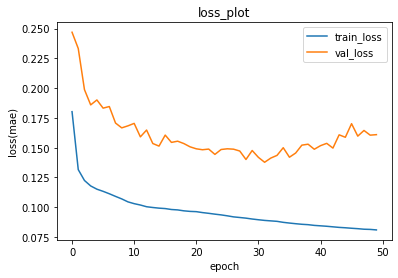

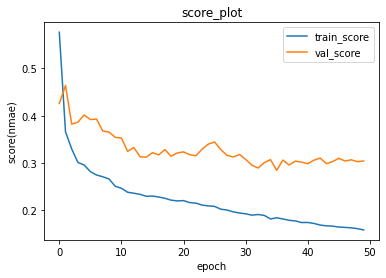

In [ ]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mae)')
plt.title('loss_plot')
plt.legend()
plt.show()

plt.plot(score_plot, label='train_score')
plt.plot(val_score_plot, label='val_score')
plt.xlabel('epoch')
plt.ylabel('score(nmae)')
plt.title('score_plot')
plt.legend()
plt.show()

## 베스트모델 복원

In [ ]:
model = torch.load(save_path)
model = model.to(device)

## 추론 및 제출

In [ ]:
def predict(encoder_input):
    model.train()
    encoder_input = encoder_input.to(device)
    decoder_input = torch.zeros([1, future_size+1, target_n], dtype=torch.float32).to(device)
    with torch.no_grad():
        output = model(encoder_input, decoder_input, False)
    return output.cpu()

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Dacon_data/sample_submission.csv')

In [ ]:
public_date_list = submission[submission['예측대상일자'].str.contains('2020')]['예측대상일자'].str.split('+').str[0].unique()

### 추론

일자별 추론을 진행합니다.

data leakage가 발생하지 않도록 주의합니다.

In [ ]:
outputs = []
troch_norm = torch.tensor(norm.to_numpy()[2::2])
for date in public_date_list:
    test_df = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Data/Dacon_data/public_data/test_files/test_{date}.csv')
    data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Dacon_data/public_data/train.csv')
    data = pd.concat([data, test_df]).iloc[-window_size:]
    
    week_day_map = {}
    for i, d in enumerate(data['요일'].unique()):
        week_day_map[d] = i
    data['요일'] = data['요일'].map(week_day_map)
    data = data.iloc[:,1:]/norm
    
    encoder_input = torch.tensor(data.to_numpy(), dtype=torch.float32)
    encoder_input = encoder_input.unsqueeze(0)
    output = predict(encoder_input)*troch_norm
    
    idx = submission[submission['예측대상일자'].str.contains(date)].index
    submission.loc[idx, '배추_가격(원/kg)':] = output[0,[6,13,27]].numpy()

In [ ]:
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/Data/Dacon_data/dacon_baseline.csv', index=False)

제출 API 사용법 => https://dacon.io/forum/403557

In [ ]:
# !pip install dacon_submit_api-0.0.4-py3-none-any.whl

Processing ./dacon_submit_api-0.0.4-py3-none-any.whl


In [ ]:
# from dacon_submit_api import dacon_submit_api 

# result = dacon_submit_api.post_submission_file(
#     '/content/drive/MyDrive/Colab Notebooks/Data/Dacon_data/dacon_baseline.csv', 
#     '90f0735322c13e8725dffa8b314e1d4a41c50ae6af466fa2e2bd5079b9253803', 
#     '235801', 
#     'DACONIO', 
#     'DACON_Baseline'
# )

{'isSubmitted': True, 'detail': 'Success'}


## Public LB Score : 0.3225